## Random walks on ontologies

We will initially use a set of tools to (a) classify an ontology (with or without an ABox), (b) perform random walks on the ontology, and (c) generate an embedding function using a skip-gram model.

We will use prebuilt tools to generate our first set of embeddings using random walks. First, we process RDF and OWL to convert the data to an edgelist format using this groovy script:

```usage: groovy RDFWrapper
 -c,--classify <arg>             use an OWL reasoner to classify the RDF
                                 dataset (must be in RDF/XML) before graph
                                 generation (default: false)
 -d,--ontology-directory <arg>   directory with ontologies to use for
                                 reasoning
 -f,--format <arg>               RDF format; values are "RDF/XML",
                                 "N-TRIPLE", "TURTLE" and "N3" (default:
                                 RDF/XML)
 -h,--help                       this information
 -i,--input <arg>                input RDF file
 -m,--mapping-file <arg>         output mapping file; has numerical ids
                                 for all entities
 -o,--output <arg>               output file for DeepWalk algorithm
 -u,--undirected <arg>           build undirected graph (default: false)
```

We apply this to a (relatively) small graph of yeast proteins, their interactions, and their GO functions:

In [1]:
!groovy walking-rdf-and-owl/RDFWrapper.groovy -i data/data-train/yeast-classes-rdf.nt -o data/yeast-classes-rdf.list -m data/yeast-classes-rdf.map -f N-TRIPLE

SLF4J: Failed to load class "org.slf4j.impl.StaticLoggerBinder".
SLF4J: Defaulting to no-operation (NOP) logger implementation
SLF4J: See http://www.slf4j.org/codes.html#StaticLoggerBinder for further details.


This will generate two new files in the data directory: an edgelist in which nodes and edges are represented by numbers, and a mapping file so we know which number corresponds to which entity (nodes or edges).

Next, we perform random walks on this dataset. You can use a Python implementation or a somewhat faster C++ implementation:

In [2]:
!walking-rdf-and-owl/deepwalk data/yeast-classes-rdf.list data/yeast-classes-rdf.walks

Building graph from data/yeast-classes-rdf.list
Number of nodes in graph: 50664
Writing walks to data/yeast-classes-rdf.walks
50293 tasks pending.


The result is a file with a set of "walks". These walks form "sentences" that describe the entities in the graph we generated. We use a neural language model (Word2Vec's skipgram model) on these sentences to generate the embeddings. There are many implementations of the skipgram model, we will use Facebook's FastText implementation here as it is one of the fastest.

In [3]:
!fastText/fasttext skipgram -input data/yeast-classes-rdf.walks -output data/yeast-classes-rdf.model -minCount 1

Read 212M words
Number of words:  50676
Number of labels: 0
Progress: 100.0% words/sec/thread:  144100 lr:  0.000000 loss:  0.200549 ETA:   0h 0m loss:  0.317834 ETA:   0h 9m loss:  0.291879 ETA:   0h 9m loss:  0.272876 ETA:   0h 9m loss:  0.255231 ETA:   0h 8m 0.045336 loss:  0.251553 ETA:   0h 8m 0.251647 ETA:   0h 8m 0.249148 ETA:   0h 8m 0.042794 loss:  0.244270 ETA:   0h 8m 0.042090 loss:  0.242864 ETA:   0h 8m 0.242285 ETA:   0h 8m loss:  0.241604 ETA:   0h 7m ETA:   0h 7m 0.038579 loss:  0.238171 ETA:   0h 7m 0.036733 loss:  0.233624 ETA:   0h 7m ETA:   0h 7m 0.036285 loss:  0.232431 ETA:   0h 7m lr:  0.036053 loss:  0.231833 ETA:   0h 7m ETA:   0h 6m lr:  0.031401 loss:  0.227461 ETA:   0h 6m 0.031026 loss:  0.227414 ETA:   0h 6m 0.030797 loss:  0.226928 ETA:   0h 6m 0.030564 loss:  0.226648 ETA:   0h 6m 0.226070 ETA:   0h 5m 0.225057 ETA:   0h 5m 0.224611 ETA:   0h 5m 0.025936 loss:  0.221929 ETA:   0h 5m 145489 lr:  0.025729 loss:  0.221624 ETA:   0h 5m 0.024892 loss:  0.2199

Now that we have generated the embedding function and the corresponding vectors for each entity (in `data/yeast-classes-rdf.model.vec`), we can use them for other tasks: clustering, similarity-search (using cosine similarity), or as feature vectors. We first read these vectors and the mappings into a dataframe and do some processing.

In [4]:
import numpy as np
import pandas as pd

embeddings = pd.read_csv('data/yeast-classes-rdf.model.vec', header = None, skiprows = 1, sep = ' ')
embds_data = embeddings.values
embeddings_dict = dict(zip(embds_data[:,0],embds_data[:,1:-1]))

mappings = pd.read_csv('data/yeast-classes-rdf.map', header = None, sep = '\t')
mps = mappings.values
mappings_dict = dict(zip(mps[:,1],mps[:,0]))

embarr = {}
for item in embeddings_dict:
    if str(item).isdigit():
        if int(item) in mappings_dict:
            ent = mappings_dict[int(item)]
            embarr[ent] = np.array(embeddings_dict[item], dtype = 'float')

size = len(embarr['http://www.w3.org/2000/01/rdf-schema#subClassOf'])
embeds = np.zeros((len(embarr), size), dtype=np.float32)
for i, emb in enumerate(embarr.values()):
    embeds[i, :] = emb
nodemap = {}
for i, m in enumerate(embarr.keys()):
    nodemap[i] = m


/home/leechuck/.pyenv/versions/3.6.0/envs/general/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


We can now visualize the embedding we generated using a dimensionality reduction method such as TSNE which projects the vectors on two dimensions.

In [5]:
from matplotlib import pyplot as plt
#from sklearn.manifold import TSNE
from MulticoreTSNE import MulticoreTSNE as TSNE

X = TSNE(n_components=2, verbose=1, n_iter=2500, n_jobs=8).fit_transform(embeds)


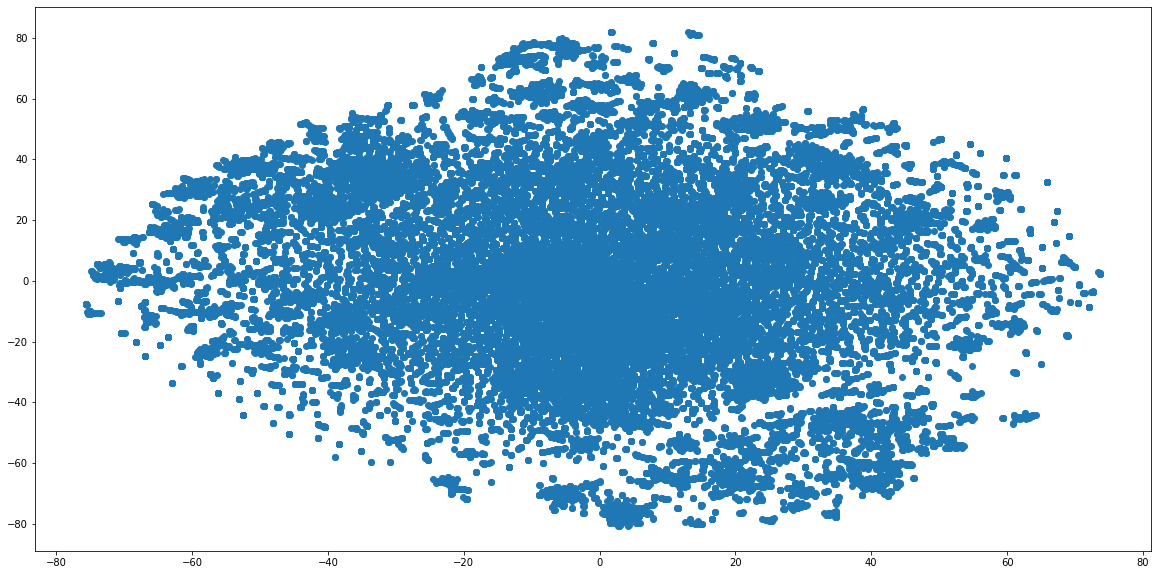

In [6]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(20, 10))
plt.scatter(X[:, 0], X[:, 1], marker='o')


This may provide us with an overview, but it is a bit hard to figure out what is going on. So next we only plot the proteins which are enzymes and we also color them based on their EC number.

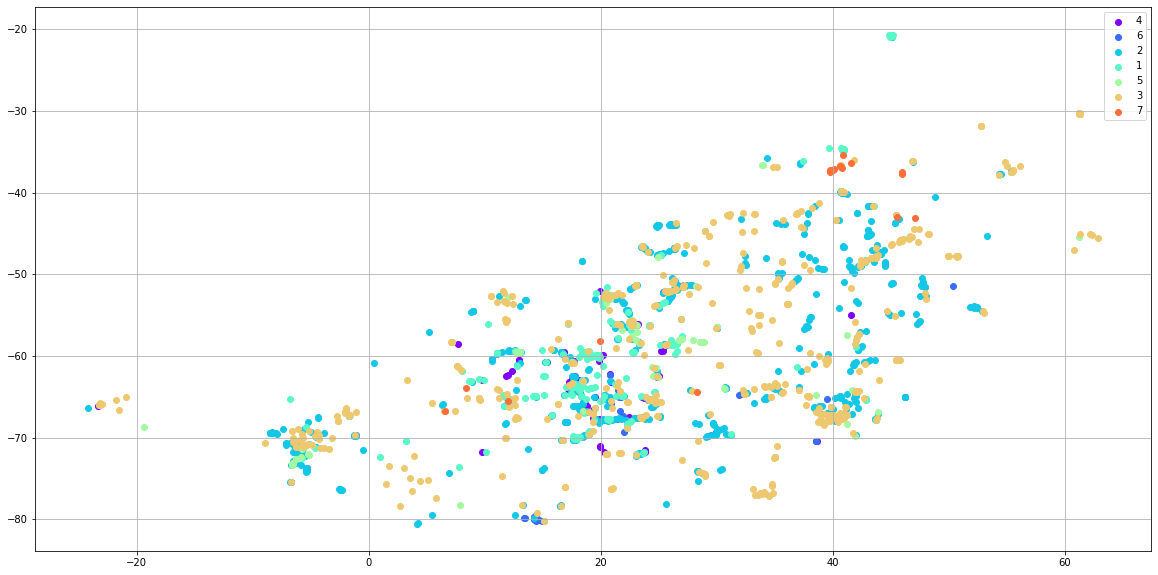

In [10]:
import matplotlib as mpl

ec_numbers = {}
with open('data/yeast_ec.tab') as f:
    next(f)
    for line in f:
        it = line.strip().split('\t', -1)
        if len(it) < 5:
            continue
        if it[3]:
            prot_id = it[3].split(';')[0]
            prot_id = 'http://{0}'.format(prot_id)    
            ec_numbers[prot_id] = it[4]
            
classes = {'0': [[], []]}
for item in nodemap.items():
    k, v = item
    if v in ec_numbers:
        ec = ec_numbers[v].split('.')[0]
        if ec not in classes:
            classes[ec] = [[], []]
        classes[ec][0].append(X[k, 0])
        classes[ec][1].append(X[k, 1])
        
colors = iter(mpl.cm.rainbow(np.linspace(0, 1, len(classes))))
fig, ax = plt.subplots(figsize=(20, 10))

for ec, items in classes.items():
    if ec == '0':
        continue
    color = next(colors)
    ax.scatter(items[0], items[1], color=color, label=ec)

ax.legend()
ax.grid(True)

plt.show()

Visualization is not the only thing we can do with the vectors; we can also do similarity-based search, clustering, or use them as general feature vectors. We can search for similar proteins like this: 

In [11]:
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine

query = 'http://4932.YOR234C'
qemb = ""
for item in nodemap:
    if nodemap[item] == query:
        qemb = embeds[item]

maxsim = 0.0
maxent = ""
for item in nodemap:
    if "4932." in nodemap[item]:
        if nodemap[item] != query:
            emb = embeds[item]
            sim = cosine(emb, qemb)
            if sim > maxsim:
                maxsim = sim
                maxent = nodemap[item]
print(maxent, maxsim)

http://4932.YJL160C 0.802695706486702


We can also get all the similarity values in a list (here just the top 10):

In [12]:
from itertools import islice

query = 'http://4932.YOR234C'
qemb = ""
for item in nodemap:
    if nodemap[item] == query:
        qemb = embeds[item]

cosine_sim={}
for item in nodemap:
    if "4932." in nodemap[item]:
        if nodemap[item] != query:
            emb = embeds[item]
            sim = cosine(emb, qemb)
            cosine_sim[nodemap[item]] = sim
            
sortedmap=sorted(cosine_sim,key=cosine_sim.get, reverse=True)
iterator=islice(sortedmap,10)
i =1
for d in iterator:
    print (str(i)+". "+ str(d) +"\t"+str(cosine_sim[d])+"\n")
    i +=1

1. http://4932.YJL160C	0.802695706486702

2. http://4932.YDR540C	0.7844169288873672

3. http://4932.YLR154W-C	0.7747373282909393

4. http://4932.YER187W	0.7666620463132858

5. http://4932.YDR015C	0.7652493864297867

6. http://4932.YNL035C	0.7638326734304428

7. http://4932.YLR118C	0.7633718699216843

8. http://4932.YLR253W	0.753849983215332

9. http://4932.YGR049W	0.7529744952917099

10. http://4932.YML066C	0.7526805102825165



## Translational embeddings with PyKEEN

This notebook will set up a basic training procedure for a TransE model using the PyKEEN package. We will use an interaction network for yeast (from the STRING database) together with GO functions of yeast protein to test the embedding function.

For this tutorial to work, install PyKEEN following the instructions at https://github.com/SmartDataAnalytics/PyKEEN.

We start with basic imports and setting up our environment:

In [13]:
import logging
import os
import sys
import time

import numpy as np
import matplotlib.pyplot as plt
import pykeen
from pykeen.kge_models import TransE

In [14]:
%matplotlib inline

In [15]:
logging.basicConfig(level=logging.INFO)
logging.getLogger('pykeen').setLevel(logging.INFO)

In [16]:
print(sys.version)

3.6.0 (default, Jul 27 2019, 09:24:03) 
[GCC 8.3.0]


In [17]:
print(time.asctime())

Mon Jul 29 16:55:10 2019


In [18]:
print(pykeen.get_version())

0.0.25


Check which hyper-parameters are required by TransE:

In [19]:
TransE.hyper_params

['embedding_dim',
 'margin_loss',
 'learning_rate',
 'scoring_function',
 'normalization_of_entities']

Define output directory:

In [20]:
output_directory = 'data/'

Define hyper-parameters inclduing the evaluation information:
 * If no test set is available define the ration of the training set that should be used as test set: **test_set_ratio**
 * Define whether you want to compute the metrics (mean rank and hits@k) in raw or in a filtered setting: **filter_negative_triples**
 
 This is the basic set of parameters for a TransE model; other models may require slightly different parameters.
 
 Unless you have a powerful GPU or use a different dataset than the one provided, set the number of epochs to a low number (5 or 10) for this tutorial; when you want to use and apply the model for a prediction task later, train for more epochs (ideally, on a good GPU).

In [21]:
config = dict(
    training_set_path           = 'data/data-train/yeast-plain.nt',
    execution_mode              = 'Training_mode',
    random_seed                 = 2,
    kg_embedding_model_name     = 'TransE',
    embedding_dim               = 50,
    scoring_function            = 1,  # corresponds to L1
    normalization_of_entities   = 2,  # corresponds to L2
    margin_loss                 = 3,
    learning_rate               = 0.1,
    num_epochs                  = 10,  
    batch_size                  = 32,
    filter_negative_triples     = True,
    preferred_device            = 'gpu'
)

### Train TransE:

We will now generate the embedding function for TransE. If you don't want to write code for any of this, PyKEEN also provides command-line tools to do the training and evaluation. Instead of the `dict` above you would create a `.json` file with the same content and use `pykeen -c config.json` to start training. You can find more information on PyKEEN at https://github.com/SmartDataAnalytics/PyKEEN.

In [22]:
results = pykeen.run(
    config=config,
    output_directory=output_directory,
)

INFO:pykeen.utilities.pipeline:-------------Train KG Embeddings-------------
Training epoch: 100%|██████████| 10/10 [05:56<00:00, 35.73s/it]


### Check result entries:

In [23]:
results.results.keys()

odict_keys(['trained_model', 'losses', 'entity_to_embedding', 'relation_to_embedding', 'entity_to_id', 'relation_to_id', 'final_configuration'])

### Losses

This plot shows us how well our model learns. We can see that the loss is still increasing, so we should try again with a higher number of epochs. We would stop training when we our loss is no longer decreasing (may take hundreds or thousands of epochs).

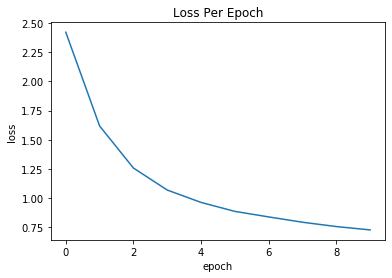

In [24]:
losses = results.results['losses']
epochs = np.arange(len(losses))
plt.title(r'Loss Per Epoch')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(epochs, losses)
plt.show()

### Save embeddings:

The embeddings provided in the data package have been trained for 100 epochs and may provide better results; you may want to skip this step.

In [26]:
import pandas as pd

classes = list(results.results['entity_to_embedding'].keys())
cls_embeds = list(results.results['entity_to_embedding'].values())

df = pd.DataFrame({'classes': classes, 'embeddings': cls_embeds})
df.to_pickle('data/transe/cls_embeddings.pkl')

relations = list(results.results['relation_to_embedding'].keys())
rel_embeds = list(results.results['relation_to_embedding'].values())
df = pd.DataFrame({'relations': relations, 'embeddings': rel_embeds})
df.to_pickle('data/transe/rel_embeddings.pkl')


### Evaluation results on test set:
 * Hits@k, k $\in$ {10, 100}
 * Mean rank
 * ROC AUC

In [28]:
from scipy.stats import rankdata

def load_test_data(data_file, classes, relations):
    data = []
    rel = f'http://interacts'
    with open(data_file, 'r') as f:
        for line in f:
            it = line.strip().split()
            id1 = f'http://{it[0]}'
            id2 = f'http://{it[1]}'
            if id1 not in classes or id2 not in classes or rel not in relations:
                continue
            data.append((id1, rel, id2))
    return data

def compute_rank_roc(ranks, n_prots):
    auc_x = list(ranks.keys())
    auc_x.sort()
    auc_y = []
    tpr = 0
    sum_rank = sum(ranks.values())
    for x in auc_x:
        tpr += ranks[x]
        auc_y.append(tpr / sum_rank)
    auc_x.append(n_prots)
    auc_y.append(1)
    auc = np.trapz(auc_y, auc_x) / n_prots
    return auc

cls_df = pd.read_pickle('data/transe/cls_embeddings.pkl')
rel_df = pd.read_pickle('data/transe/rel_embeddings.pkl')
classes = {v: k for k, v in enumerate(cls_df['classes'])}
relations = {v: k for k, v in enumerate(rel_df['relations'])}

nb_classes = len(cls_df)
nb_relations = len(rel_df)
embeds_list = cls_df['embeddings'].values
rembeds_list = rel_df['embeddings'].values
size = len(embeds_list[0])
embeds = np.zeros((nb_classes, size), dtype=np.float32)
for i, emb in enumerate(embeds_list):
    embeds[i, :] = emb

proteins = {}
for k, v in classes.items():
    if not k.startswith('<http://purl.obolibrary.org/obo/GO_'):
        proteins[k] = v

prot_index = list(proteins.values())
prot_embeds = embeds[prot_index, :]
prot_dict = {v: k for k, v in enumerate(prot_index)}
    
rsize = len(rembeds_list[0])
rembeds = np.zeros((nb_relations, rsize), dtype=np.float32)
for i, emb in enumerate(rembeds_list):
    rembeds[i, :] = emb

train_data = load_test_data('data/data-train/4932.protein.links.v10.5.txt', classes, relations)
valid_data = load_test_data('data/data-valid/4932.protein.links.v10.5.txt', classes, relations)
trlabels = {}
for c, r, d in train_data:
    c, r, d = prot_dict[classes[c]], relations[r], prot_dict[classes[d]]
    if r not in trlabels:
        trlabels[r] = np.ones((len(prot_embeds), len(prot_embeds)), dtype=np.int32)
    trlabels[r][c, d] = 1000
for c, r, d in valid_data:
    c, r, d = prot_dict[classes[c]], relations[r], prot_dict[classes[d]]
    if r not in trlabels:
        trlabels[r] = np.ones((len(prot_embeds), len(prot_embeds)), dtype=np.int32)
    trlabels[r][c, d] = 1000

test_data = load_test_data('data/data-test/4932.protein.links.v10.5.txt', classes, relations)
top1 = 0
top10 = 0
top100 = 0
mean_rank = 0
ftop1 = 0
ftop10 = 0
ftop100 = 0
fmean_rank = 0
labels = {}
preds = {}
ranks = {}
franks = {}
eval_data = test_data
n = len(eval_data)
for c, r, d in eval_data:
    c, r, d = prot_dict[classes[c]], relations[r], prot_dict[classes[d]]
    if r not in labels:
        labels[r] = np.zeros((len(prot_embeds), len(prot_embeds)), dtype=np.int32)
    if r not in preds:
        preds[r] = np.zeros((len(prot_embeds), len(prot_embeds)), dtype=np.float32)
    labels[r][c, d] = 1
    ec = prot_embeds[c, :]
    er = rembeds[r, :]
    ec += er

    # Compute distance
    dst = np.linalg.norm(prot_embeds - ec.reshape(1, -1), axis=1)
    res = dst.flatten()

    preds[r][c, :] = res
    index = rankdata(res, method='average')
    rank = index[d]
    if rank == 1:
        top1 += 1
    if rank <= 10:
        top10 += 1
    if rank <= 100:
        top100 += 1
    mean_rank += rank
    if rank not in ranks:
        ranks[rank] = 0
    ranks[rank] += 1

    # Filtered rank
    index = rankdata((res * trlabels[r][c, :]), method='average')
    rank = index[d]
    if rank == 1:
        ftop1 += 1
    if rank <= 10:
        ftop10 += 1
    if rank <= 100:
        ftop100 += 1
    fmean_rank += rank

    if rank not in franks:
        franks[rank] = 0
    franks[rank] += 1
top1 /= n
top10 /= n
top100 /= n
mean_rank /= n
ftop1 /= n
ftop10 /= n
ftop100 /= n
fmean_rank /= n

rank_auc = compute_rank_roc(ranks, len(proteins))
frank_auc = compute_rank_roc(franks, len(proteins))

print(f'{top10:.2f} {top100:.2f} {mean_rank:.2f} {rank_auc:.2f}')
print(f'{ftop10:.2f} {ftop100:.2f} {fmean_rank:.2f} {frank_auc:.2f}')

0.01 0.11 9421.18 0.81
0.02 0.14 9373.91 0.81


In [29]:
from matplotlib import pyplot as plt
from MulticoreTSNE import MulticoreTSNE as TSNE
X = TSNE(n_components=2, verbose=1, n_iter=2500, n_jobs=8).fit_transform(prot_embeds)


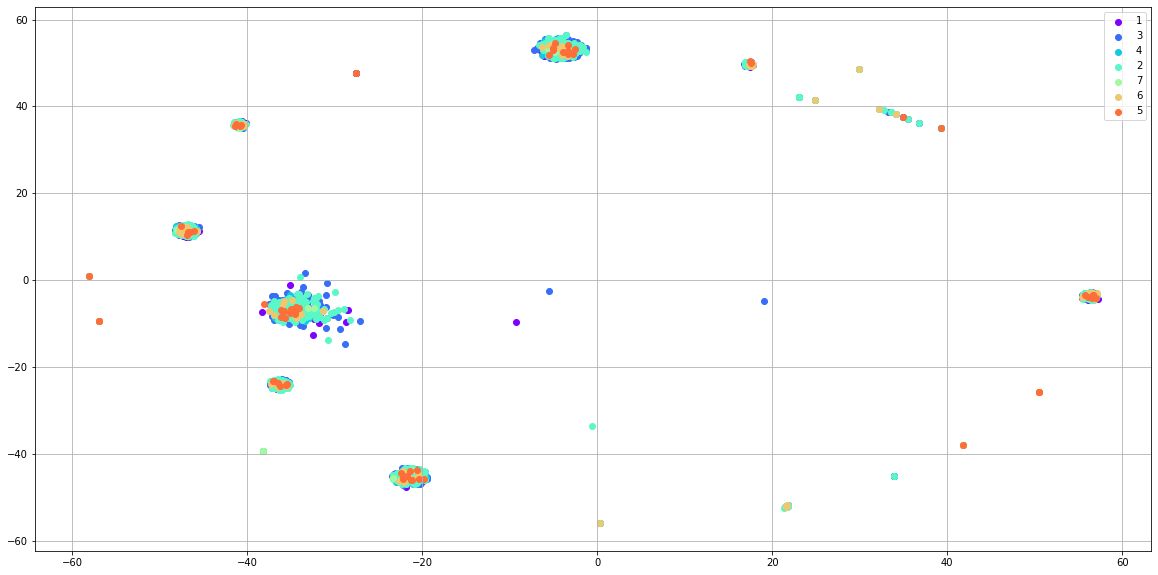

In [31]:
ec_numbers = {}
with open('data/yeast_ec.tab') as f:
    next(f)
    for line in f:
        it = line.strip().split('\t', -1)
        if len(it) < 5:
            continue
        if it[3]:
            prot_id = it[3].split(';')[0]
            prot_id = 'http://{0}'.format(prot_id)    
            ec_numbers[prot_id] = it[4]
classes = {'0': [[], []]}
for i, item in enumerate(proteins.items()):
    k, v = item
    if k in ec_numbers:
        ec = ec_numbers[k].split('.')[0]
        if ec not in classes:
            classes[ec] = [[], []]
        classes[ec][0].append(X[i, 0])
        classes[ec][1].append(X[i, 1])
colors = iter(plt.cm.rainbow(np.linspace(0, 1, len(classes))))
fig, ax = plt.subplots(figsize=(20, 10))

for ec, items in classes.items():
    if ec == '0':
        continue
    color = next(colors)
    ax.scatter(items[0], items[1], color=color, label=ec)

ax.legend()
ax.grid(True)

plt.show()